In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/Deep_learning/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep_learning/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_learning/labels120.npy",tr_labels)

#Call data from directory

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_dir = "/content/drive/MyDrive/Deep_learning/Deep Learning Assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


In [3]:
(data.shape[1], data.shape[2], data.shape[3])

(120, 120, 3)

In [4]:
labels.shape

(25000,)

In [5]:
label_pd = pd.DataFrame(labels)
label_pd.value_counts()

Colon Benign Tissue             5000
Colon adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Lung adenocarcinoma             5000
dtype: int64

# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(labels.reshape(-1, 1))
labels_new = enc.transform(labels.reshape(-1, 1))
labels_new


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

## Visualizing Sample Images

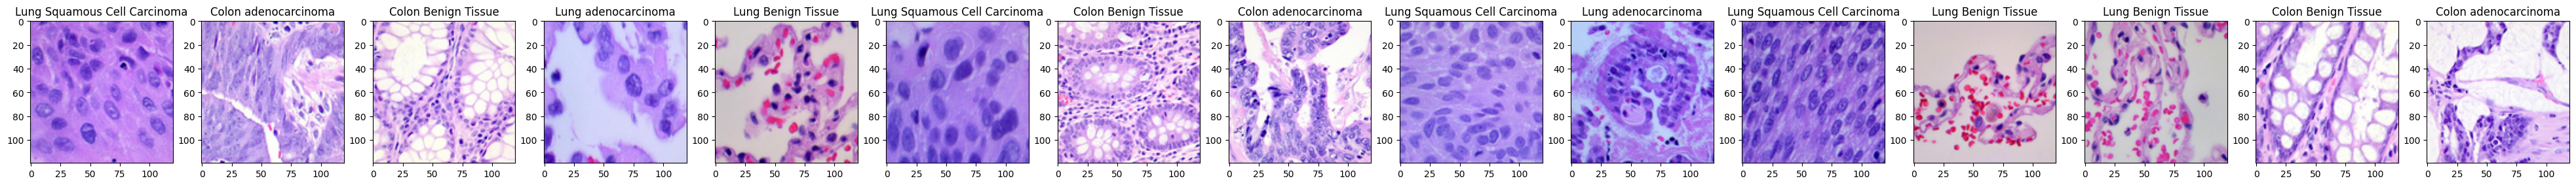

In [ ]:
num_images = data.shape[0]
random_indices = np.random.choice(num_images, size=15, replace=False)
random_15_images = data[random_indices]
images_label = labels[random_indices]
fig, axes = plt.subplots(1, 15, figsize=(50, 5))
for i, ax in zip(range(15), axes):
  ax.imshow(random_15_images[i])
  ax.set_title(images_label[i])
plt.show()


## Visualizing Class Distribution

(array(['Colon Benign Tissue', 'Colon adenocarcinoma',
       'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma',
       'Lung adenocarcinoma'], dtype='<U28'), array([5000, 5000, 5000, 5000, 5000]))
['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']
[5000 5000 5000 5000 5000]


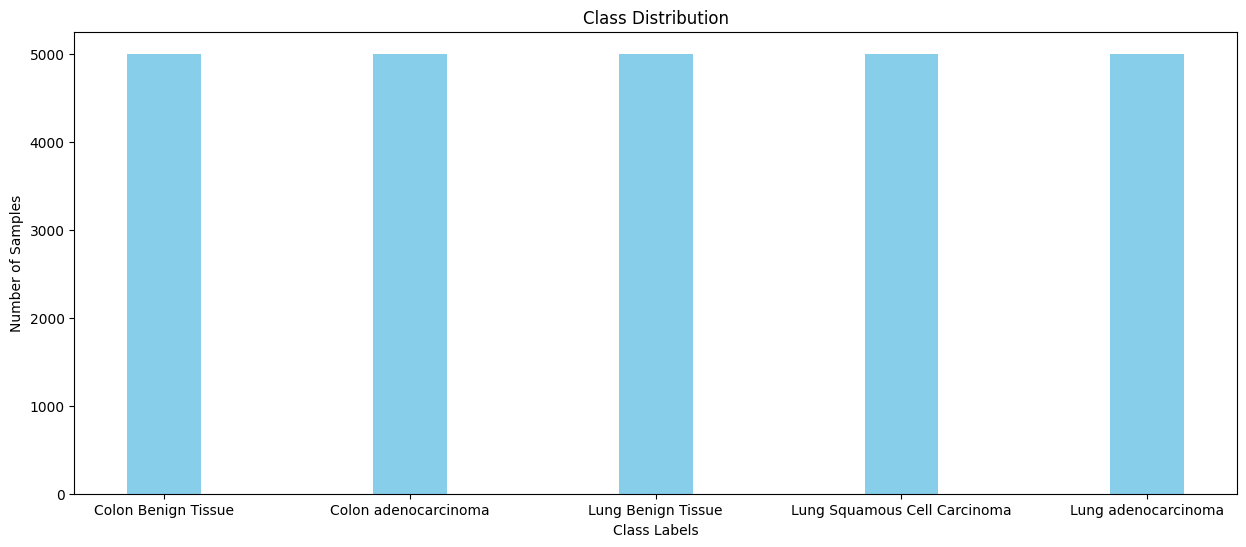

In [ ]:
# Count the occurrence of each class label
unique, counts = np.unique(labels, return_counts=True)
print(np.unique(labels, return_counts=True))
print(unique)
print(counts)


# Create bar plot
plt.figure(figsize=(15, 6))
plt.bar(unique, counts, color='skyblue',width=0.3)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(unique)
plt.show()



##Train-Test-Val Split

In [8]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels_new, test_size = 0.2, shuffle=True, stratify=labels_new, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, shuffle=True,stratify=y_trainval, random_state = 42)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 120, 120, 3) (5000, 120, 120, 3) (5000, 120, 120, 3)


# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [9]:
def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [10]:
## LOSS-ACC GRAPHS
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):

    # Extracting the loss and accuracy values for plotting
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting training and validation -- loss and accuracy
    plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
    plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')


In [11]:
#Conf matrix and Classification Report:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def confusion_matrix_and_classreport(y_true, y_pred, sets):
        # Decode the labels (only keep the one has the highest probability)
        y_true = y_true.argmax(axis=1)
        y_pred = y_pred.argmax(axis=1)
        plt.figure(figsize=(5,5))
        # Plot the heatmap
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', xticklabels = np.unique(labels), yticklabels = np.unique(labels))
        plt.title(f'{sets} Confusion Matrix')
        plt.xlabel('Predicted labels', fontsize = 10)
        plt.ylabel('True labels', fontsize = 10)
        plt.show()
        # Print the classification report
        print("Classification Report")
        print(classification_report(y_true, y_pred))


In [12]:
#ROC curves
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, sets):
    # Prepare figure
    plt.figure(figsize=(8, 5))
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all roc curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    # Plot roc curve for each class
    n_classes = y_true.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
        mean_tpr += np.interp(fpr_grid, fpr, tpr)  # linear interpolation Keep adding the tpr for the macro-average calculation)

    # Average it and compute auc
    mean_tpr /= n_classes
    roc_auc = auc(fpr_grid, mean_tpr)
    plt.plot(fpr_grid, mean_tpr, label=f'Macro-average (AUC = {roc_auc:.2f})', linestyle='--' )

    # Plot micro-average roc curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Micro-average (AUC = {roc_auc:.2f})', linestyle='--')

    # Plot chance diagnol line
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Chance')

    plt.title(f'{sets} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Baseline Model

In [ ]:

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
469/469 [==============================] - 10s 10ms/step - loss: 3.5784 - categorical_accuracy: 0.4480 - val_loss: 0.7764 - val_categorical_accuracy: 0.6196
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.6275 - categorical_accuracy: 0.6955 - val_loss: 0.6246 - val_categorical_accuracy: 0.7006
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.5204 - categorical_accuracy: 0.7487 - val_loss: 0.6327 - val_categorical_accuracy: 0.7112
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4590 - categorical_accuracy: 0.7785 - val_loss: 0.5353 - val_categorical_accuracy: 0.7524
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4304 - categorical_accuracy: 0.7953 - val_loss: 0.6019 - val_categorical_accuracy: 0.7304
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3790 - categorical_accuracy: 0.8265 - val_loss: 0.5620 - val_categorical_accuracy: 0.7666
Ep

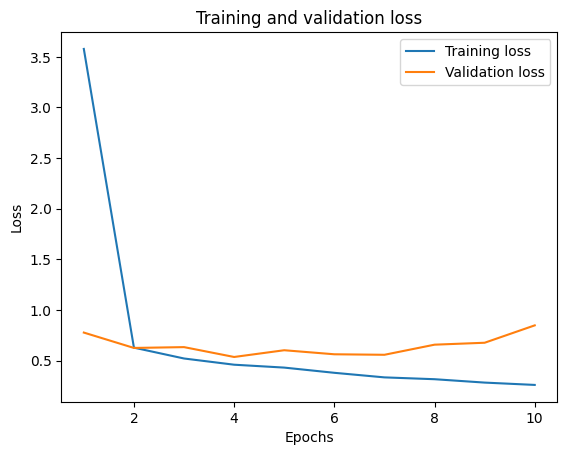

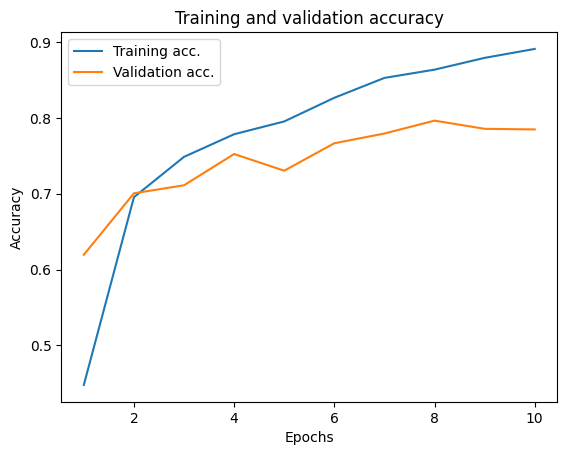

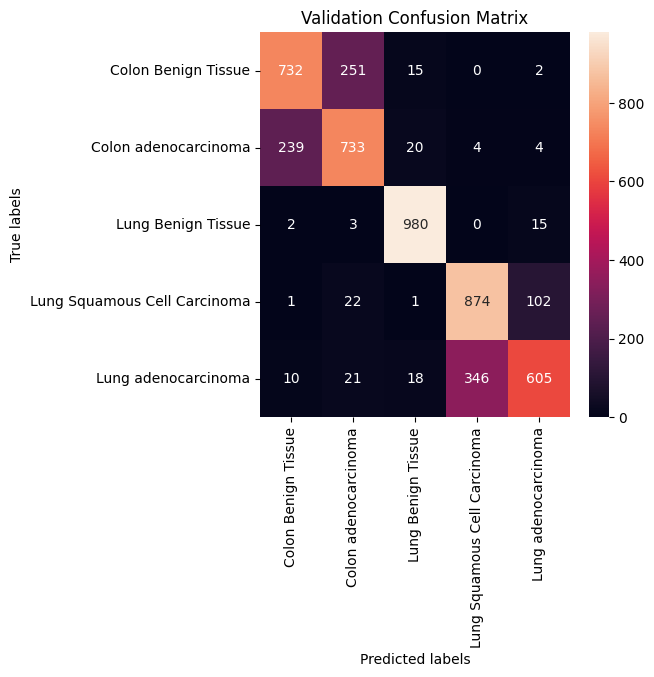

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1000
           1       0.71      0.73      0.72      1000
           2       0.95      0.98      0.96      1000
           3       0.71      0.87      0.79      1000
           4       0.83      0.60      0.70      1000

    accuracy                           0.78      5000
   macro avg       0.79      0.78      0.78      5000
weighted avg       0.79      0.78      0.78      5000



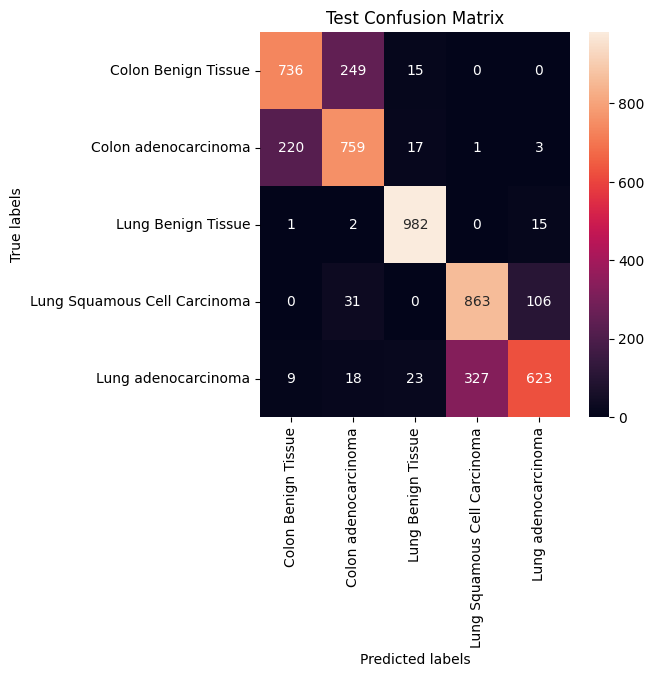

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1000
           1       0.72      0.76      0.74      1000
           2       0.95      0.98      0.96      1000
           3       0.72      0.86      0.79      1000
           4       0.83      0.62      0.71      1000

    accuracy                           0.79      5000
   macro avg       0.80      0.79      0.79      5000
weighted avg       0.80      0.79      0.79      5000



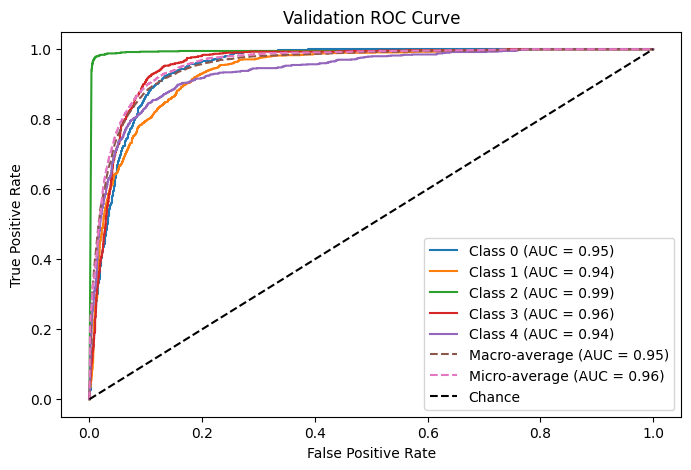

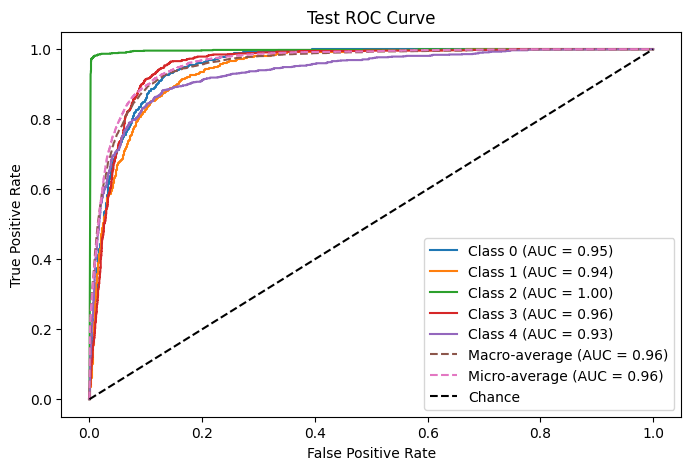

In [ ]:
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

# Enhanced Model

## Experimental model 1 -- tunning the amount of filters



In [ ]:
# define the model that could hyperparamet tunning the amount of filters
def build_model(filter_num):

        model = models.Sequential()
        model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', input_shape=(data.shape[1], data.shape[2], data.shape[3])))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(filter_num, (3, 3), padding ='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(5, activation='softmax'))
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['categorical_accuracy'])
        model.summary()

        return model

### tunning

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 115200)            0         
                                                                 
 dense_9 (Dense)             (None, 128)              

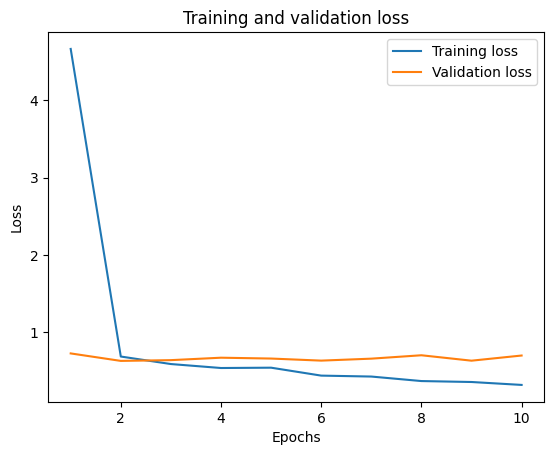

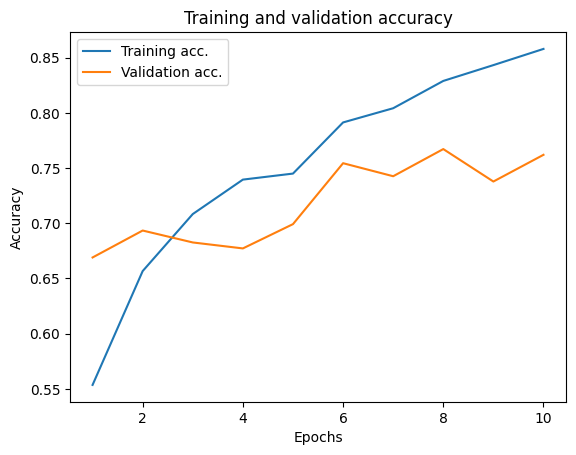

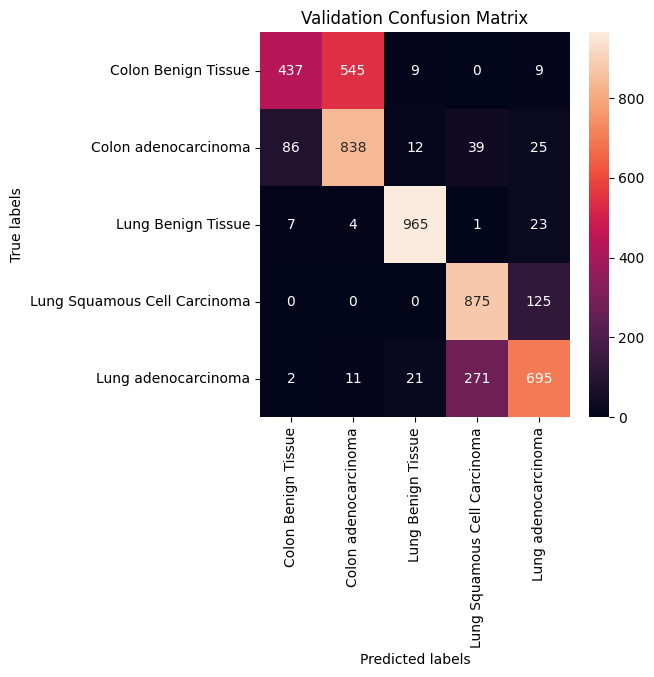

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.44      0.57      1000
           1       0.60      0.84      0.70      1000
           2       0.96      0.96      0.96      1000
           3       0.74      0.88      0.80      1000
           4       0.79      0.69      0.74      1000

    accuracy                           0.76      5000
   macro avg       0.78      0.76      0.75      5000
weighted avg       0.78      0.76      0.75      5000



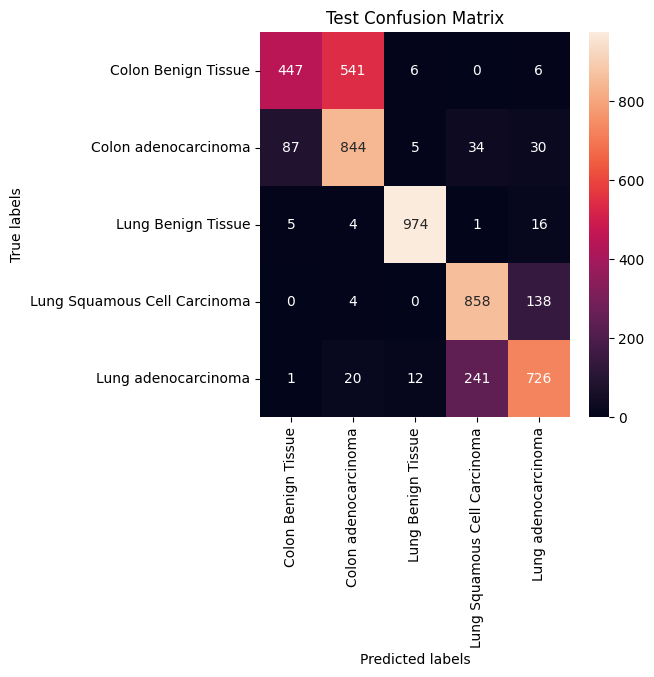

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.45      0.58      1000
           1       0.60      0.84      0.70      1000
           2       0.98      0.97      0.98      1000
           3       0.76      0.86      0.80      1000
           4       0.79      0.73      0.76      1000

    accuracy                           0.77      5000
   macro avg       0.79      0.77      0.76      5000
weighted avg       0.79      0.77      0.76      5000



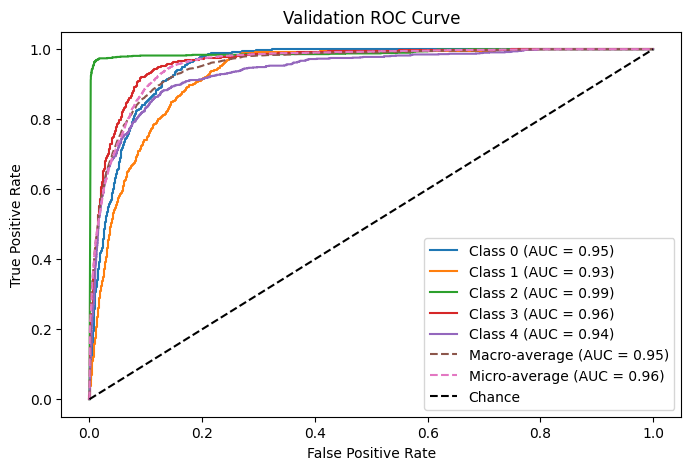

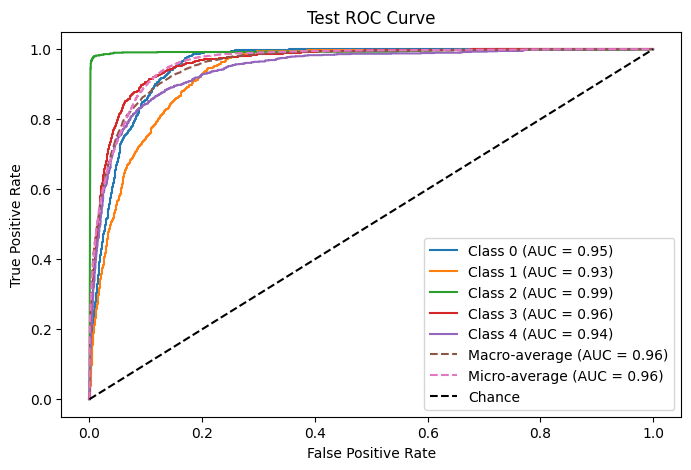

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 256)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 230400)            0         
                                                                 
 dense_12 (Dense)            (None, 128)              

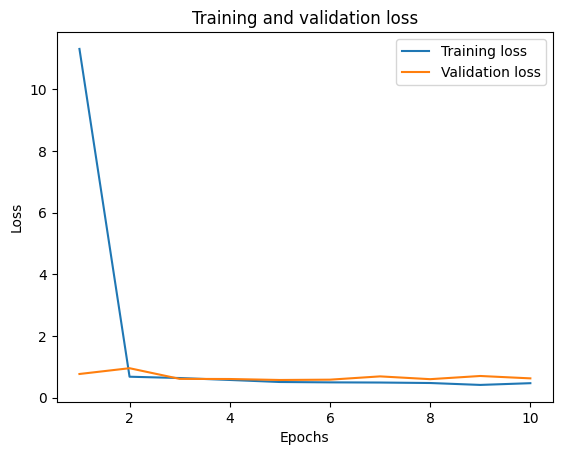

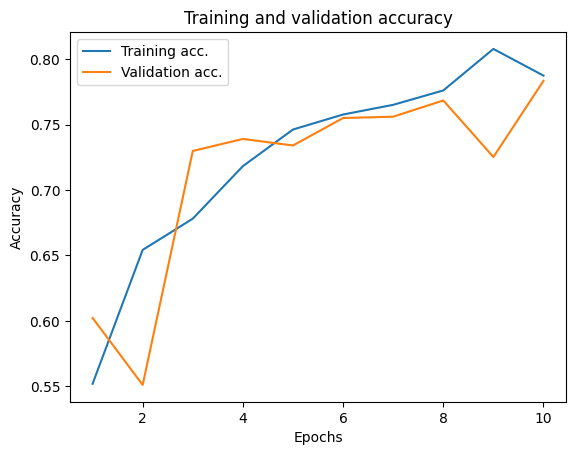

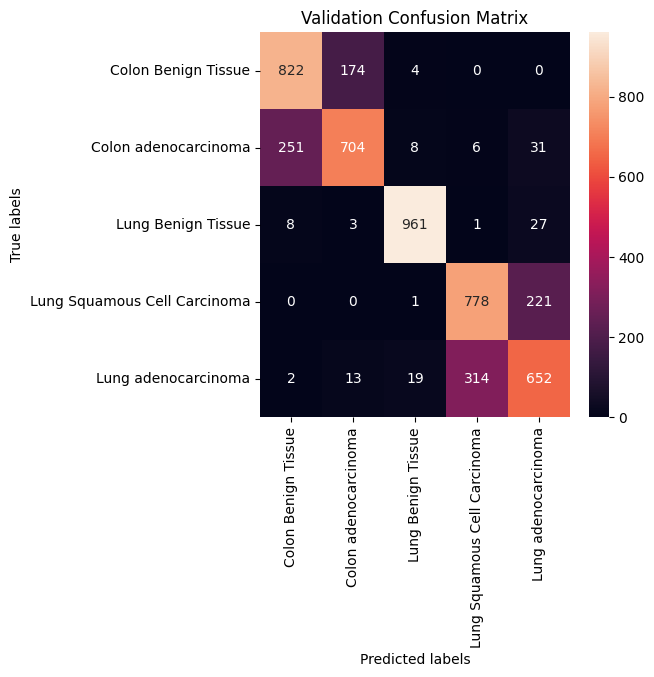

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.79      0.70      0.74      1000
           2       0.97      0.96      0.96      1000
           3       0.71      0.78      0.74      1000
           4       0.70      0.65      0.68      1000

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



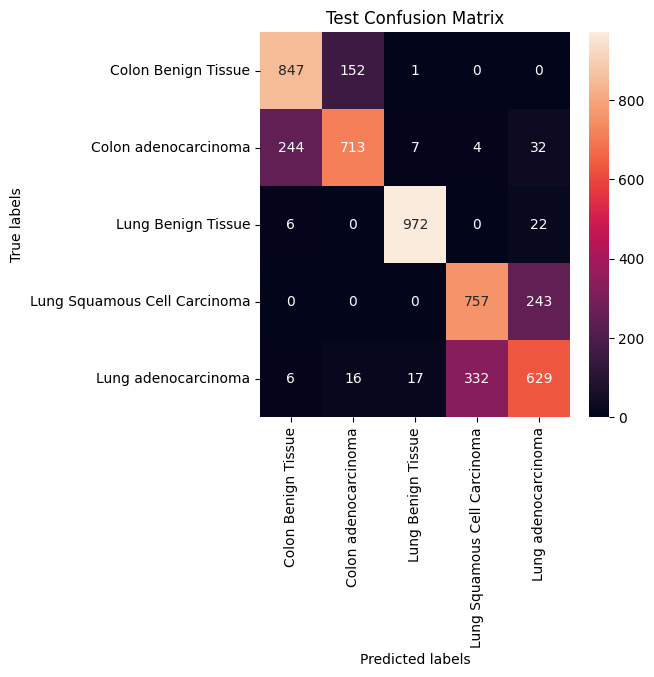

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.81      0.71      0.76      1000
           2       0.97      0.97      0.97      1000
           3       0.69      0.76      0.72      1000
           4       0.68      0.63      0.65      1000

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



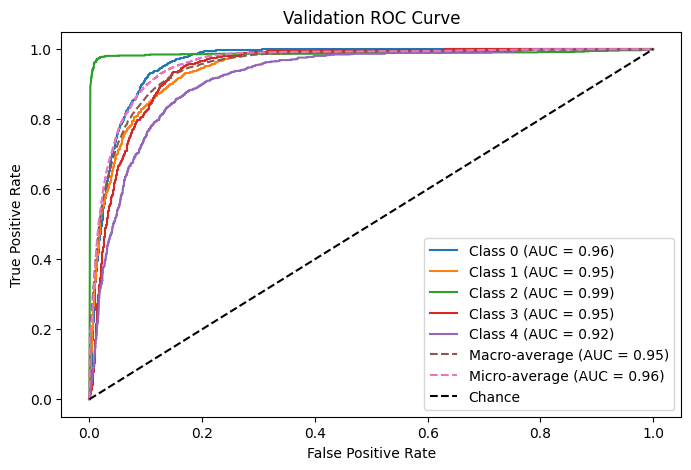

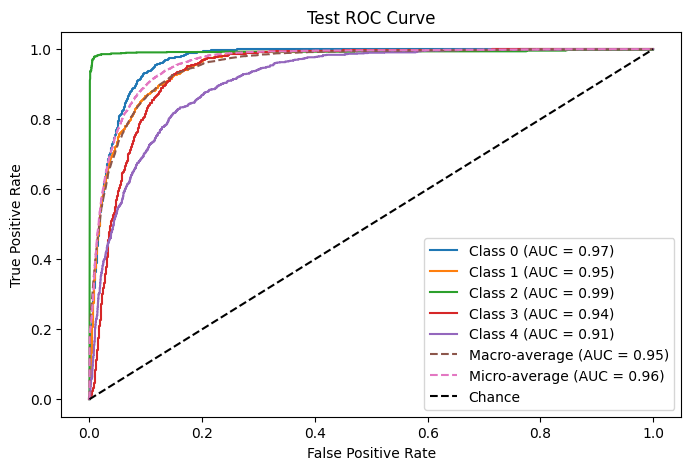

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 512)       0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 460800)            0         
                                                                 
 dense_15 (Dense)            (None, 128)              

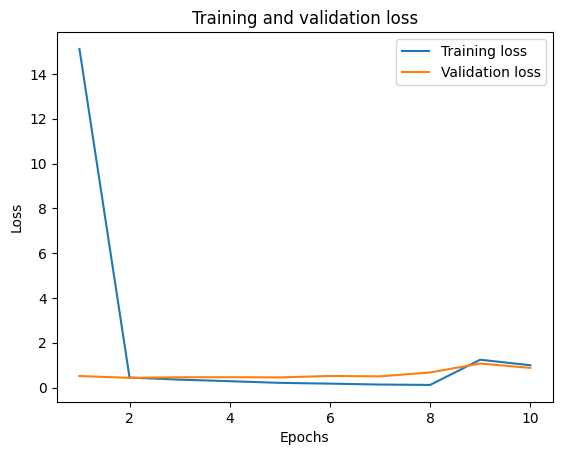

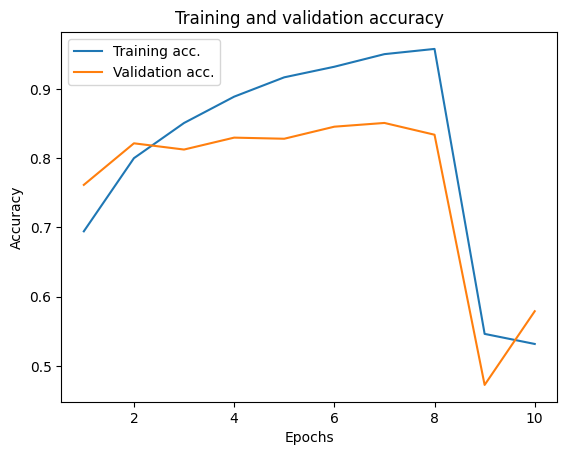

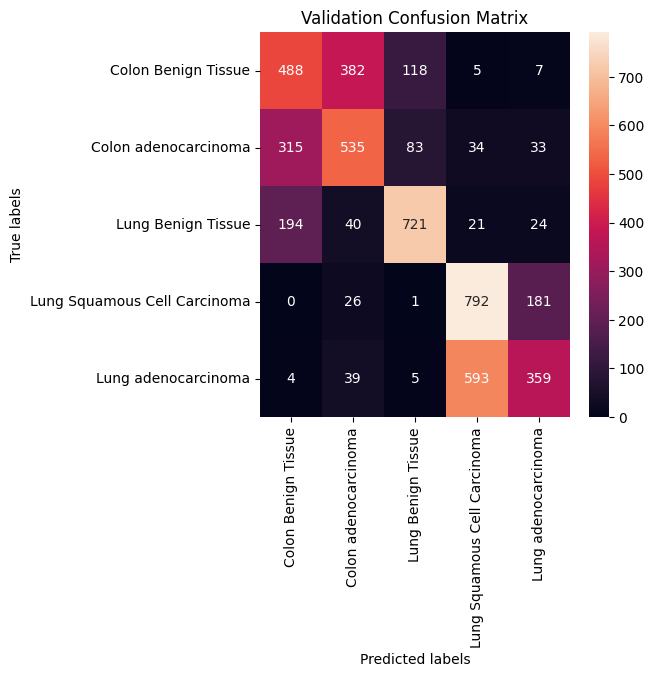

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1000
           1       0.52      0.54      0.53      1000
           2       0.78      0.72      0.75      1000
           3       0.55      0.79      0.65      1000
           4       0.59      0.36      0.45      1000

    accuracy                           0.58      5000
   macro avg       0.59      0.58      0.57      5000
weighted avg       0.59      0.58      0.57      5000



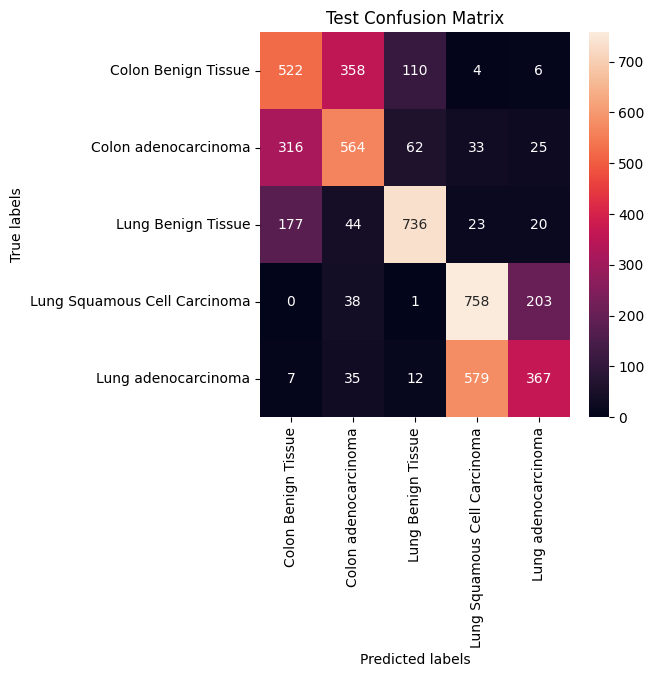

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      1000
           1       0.54      0.56      0.55      1000
           2       0.80      0.74      0.77      1000
           3       0.54      0.76      0.63      1000
           4       0.59      0.37      0.45      1000

    accuracy                           0.59      5000
   macro avg       0.60      0.59      0.58      5000
weighted avg       0.60      0.59      0.58      5000



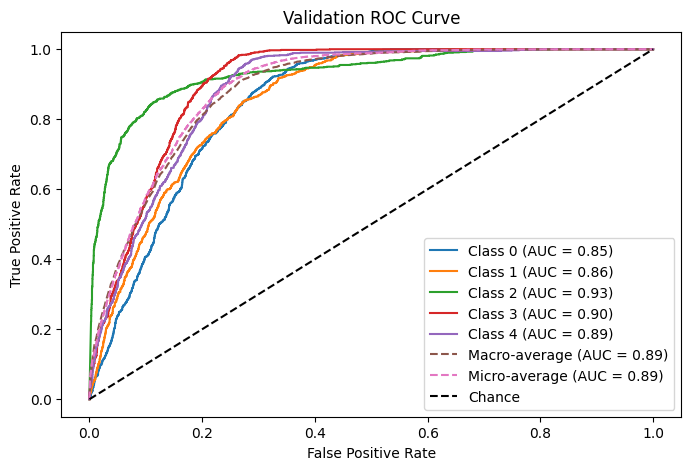

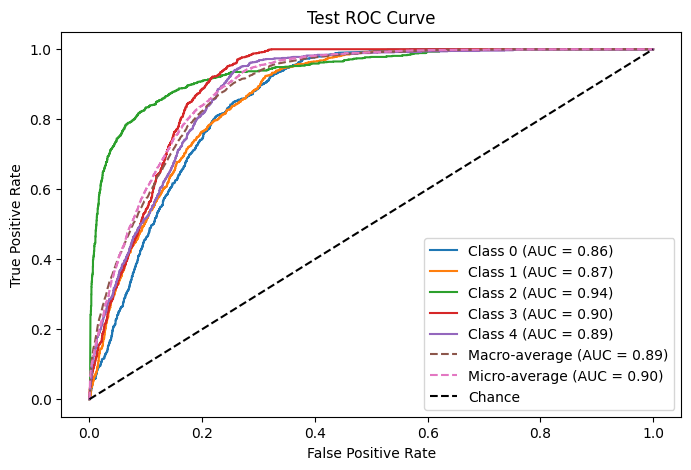

In [ ]:
filter_num_list = [128, 256, 512]
history_li = []
model_li = []
for num in filter_num_list:
  # Rebuild the model with the current number of filters
  model = build_model(filter_num = num)
  # Fit the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
  # call all the functions
  history_li.append(history)
  model_li.append(model)
  plot_loss_accuracy(history)
  confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
  confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
  plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
  plot_roc_curve(y_test, model.predict(X_test, verbose=0), "Test")



In [ ]:
model_li[1].layers[-1].weights

[<tf.Variable 'dense_8/kernel:0' shape=(32, 5) dtype=float32, numpy=
 array([[-0.31691748, -0.31897923,  0.01673805,  0.35987604,  0.00243191],
        [ 0.05464415,  0.17633608,  0.10290182,  0.3020608 ,  0.02595565],
        [-0.3412721 , -0.03624657, -0.05639736, -0.21197481, -0.02100598],
        [ 0.0897277 , -0.35843933,  0.33201578, -0.28505963,  0.01852841],
        [-0.09946284,  0.1994481 ,  0.2944185 , -0.07574245, -0.2572052 ],
        [ 0.23571326,  0.25297573, -0.32874727, -0.00367561,  0.3327071 ],
        [ 0.31642845,  0.380309  ,  0.08170752, -0.00190744,  0.11424898],
        [-0.02782236, -0.02668053,  0.36129978, -0.0487781 ,  0.3840762 ],
        [-0.10669204,  0.18534192, -0.08973008, -0.30302045, -0.02424148],
        [-0.36894307, -0.08235569,  0.17163049,  0.33881536, -0.14995064],
        [-0.21586022,  0.03668005, -0.27999133, -0.33682007, -0.34736726],
        [ 0.19163539,  0.302396  , -0.12373091,  0.23962153,  0.07791136],
        [ 0.16076039, -0.358355

## Experimental model 2 -- adding Regularizer

In [15]:
from tensorflow.keras import models, layers, regularizers
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 512)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 128)              

Epoch 1/10
469/469 [==============================] - 22s 35ms/step - loss: 17.6334 - categorical_accuracy: 0.5434 - val_loss: 1.8924 - val_categorical_accuracy: 0.6168
Epoch 2/10
469/469 [==============================] - 15s 31ms/step - loss: 1.6567 - categorical_accuracy: 0.7047 - val_loss: 1.5739 - val_categorical_accuracy: 0.7570
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 1.4211 - categorical_accuracy: 0.7711 - val_loss: 1.4406 - val_categorical_accuracy: 0.7370
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 1.3438 - categorical_accuracy: 0.7812 - val_loss: 1.6181 - val_categorical_accuracy: 0.7080
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 1.1992 - categorical_accuracy: 0.8218 - val_loss: 1.2721 - val_categorical_accuracy: 0.7838
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 1.0998 - categorical_accuracy: 0.8409 - val_loss: 1.1893 - val_categorical_accuracy

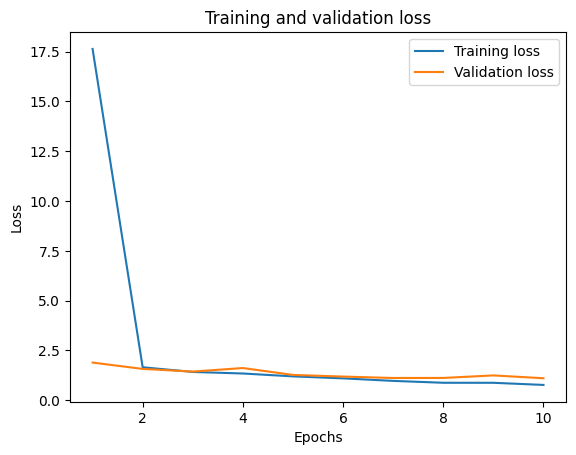

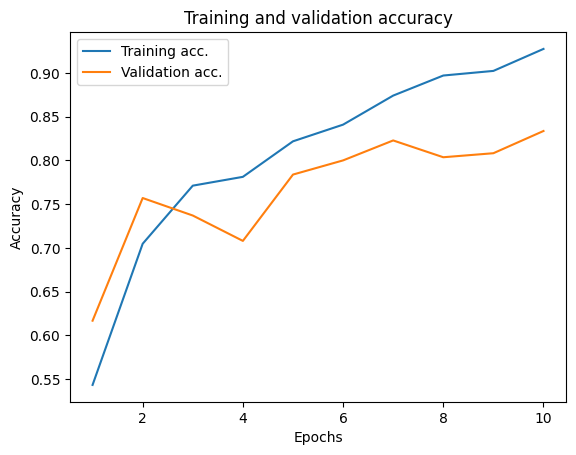

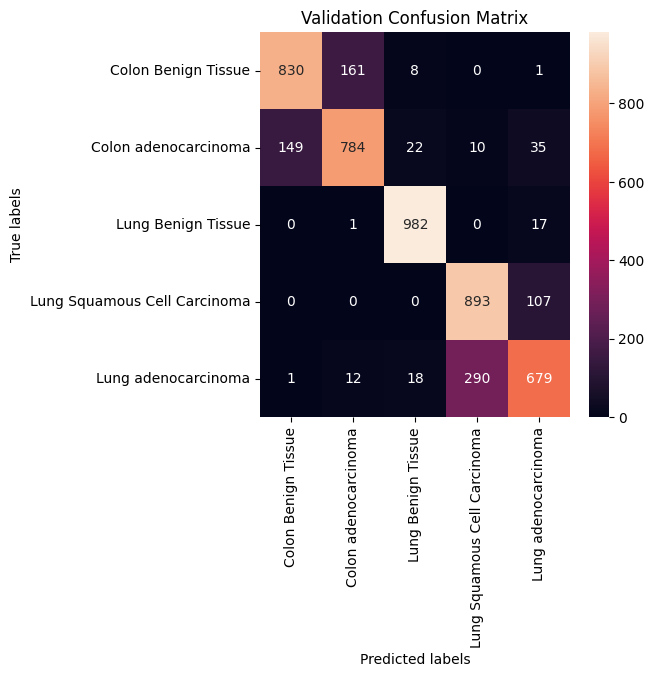

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.82      0.78      0.80      1000
           2       0.95      0.98      0.97      1000
           3       0.75      0.89      0.81      1000
           4       0.81      0.68      0.74      1000

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.84      0.83      0.83      5000



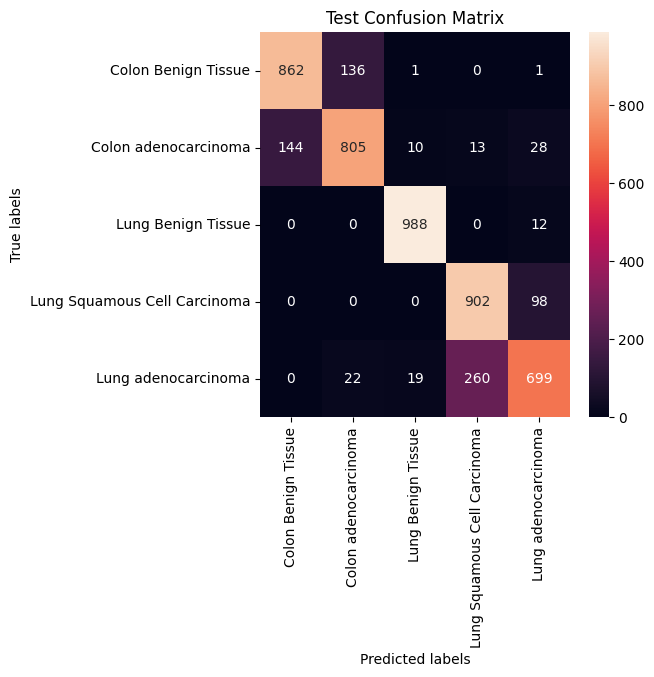

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.84      0.81      0.82      1000
           2       0.97      0.99      0.98      1000
           3       0.77      0.90      0.83      1000
           4       0.83      0.70      0.76      1000

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



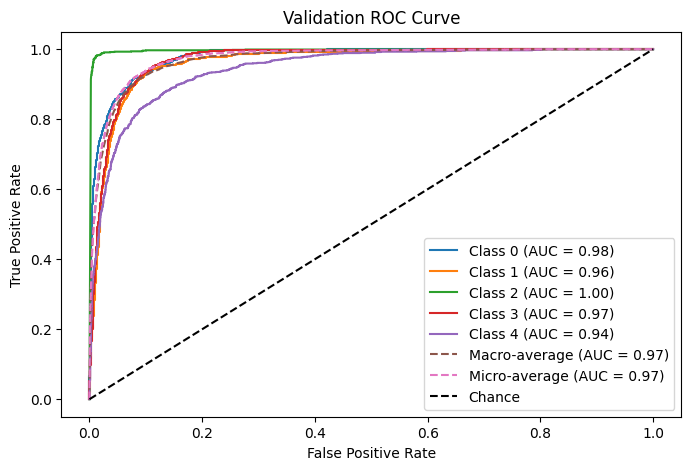

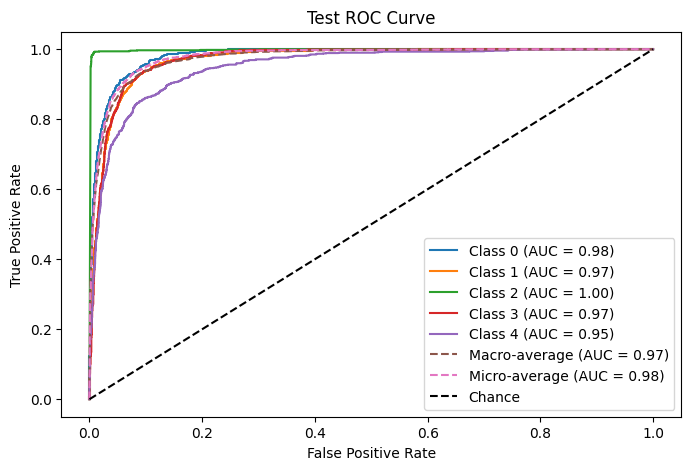

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

## Experimental model 3 -- adding more CNN layers

In [18]:
from tensorflow.keras import models, layers, regularizers
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 512)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 512)       2359808   
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 512)      

Epoch 1/10
469/469 [==============================] - 25s 46ms/step - loss: 5.0656 - categorical_accuracy: 0.6317 - val_loss: 1.6254 - val_categorical_accuracy: 0.6112
Epoch 2/10
469/469 [==============================] - 20s 42ms/step - loss: 1.1920 - categorical_accuracy: 0.8145 - val_loss: 1.0739 - val_categorical_accuracy: 0.8436
Epoch 3/10
469/469 [==============================] - 20s 42ms/step - loss: 0.9535 - categorical_accuracy: 0.8701 - val_loss: 0.8692 - val_categorical_accuracy: 0.8928
Epoch 4/10
469/469 [==============================] - 20s 42ms/step - loss: 0.7621 - categorical_accuracy: 0.9157 - val_loss: 0.6636 - val_categorical_accuracy: 0.9346
Epoch 5/10
469/469 [==============================] - 20s 42ms/step - loss: 0.6568 - categorical_accuracy: 0.9301 - val_loss: 0.6317 - val_categorical_accuracy: 0.9258
Epoch 6/10
469/469 [==============================] - 20s 42ms/step - loss: 0.5817 - categorical_accuracy: 0.9367 - val_loss: 0.6299 - val_categorical_accuracy:

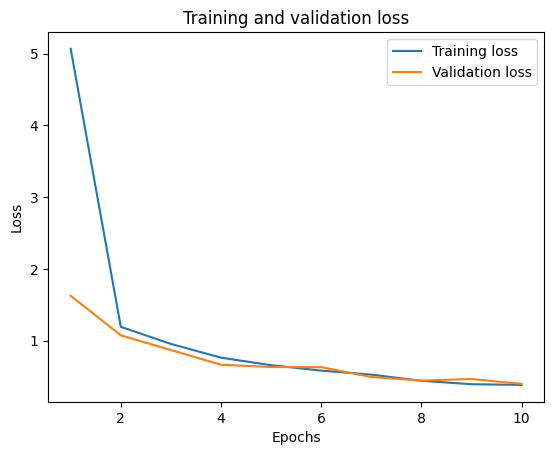

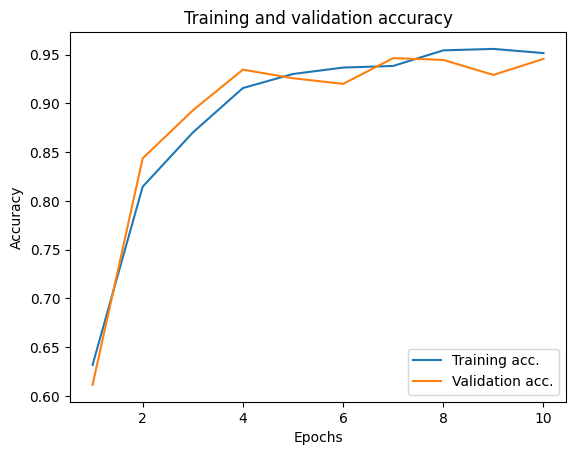

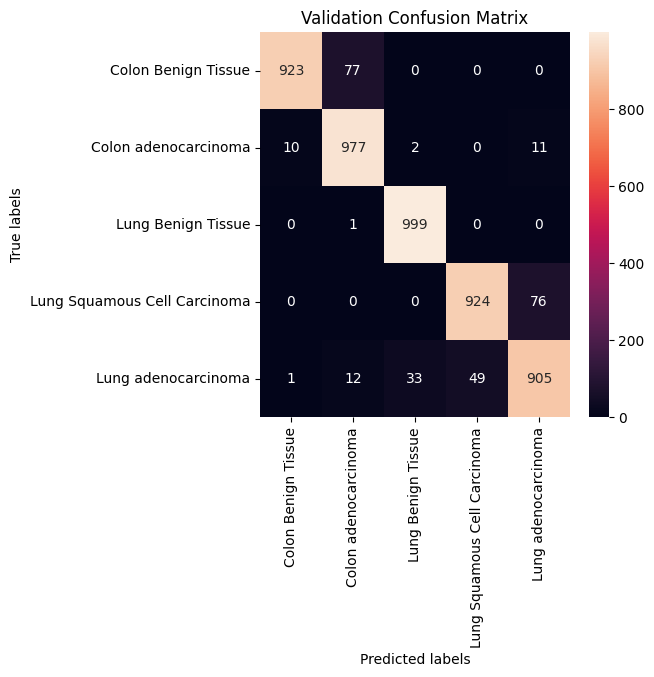

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1000
           1       0.92      0.98      0.95      1000
           2       0.97      1.00      0.98      1000
           3       0.95      0.92      0.94      1000
           4       0.91      0.91      0.91      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



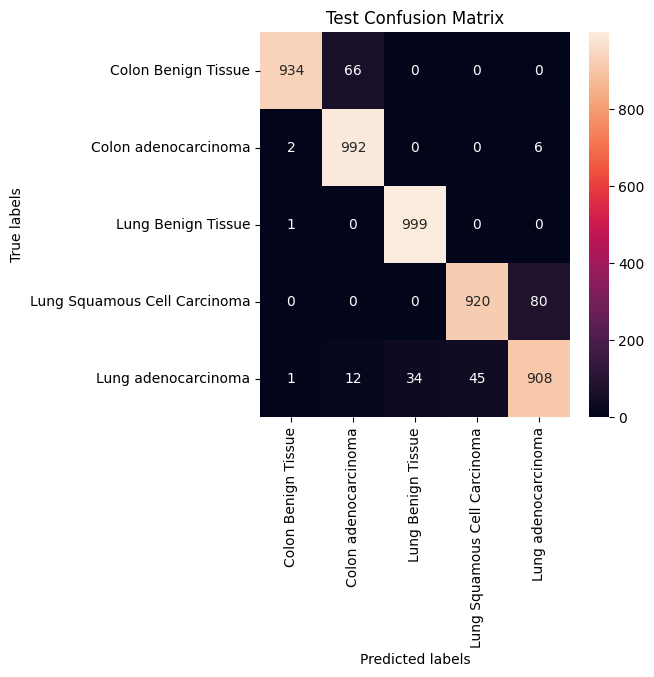

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1000
           1       0.93      0.99      0.96      1000
           2       0.97      1.00      0.98      1000
           3       0.95      0.92      0.94      1000
           4       0.91      0.91      0.91      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



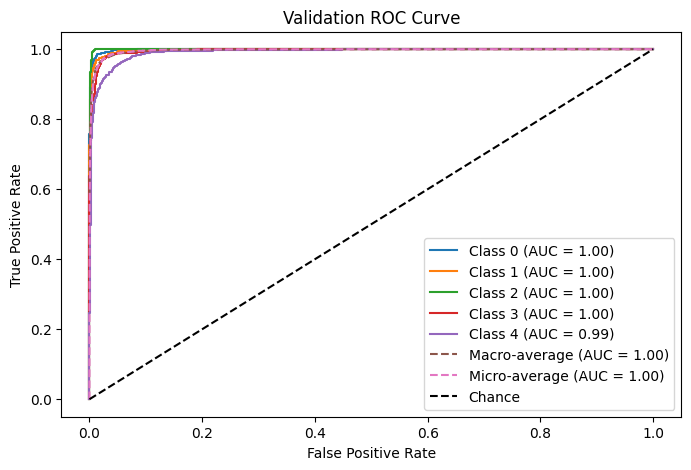

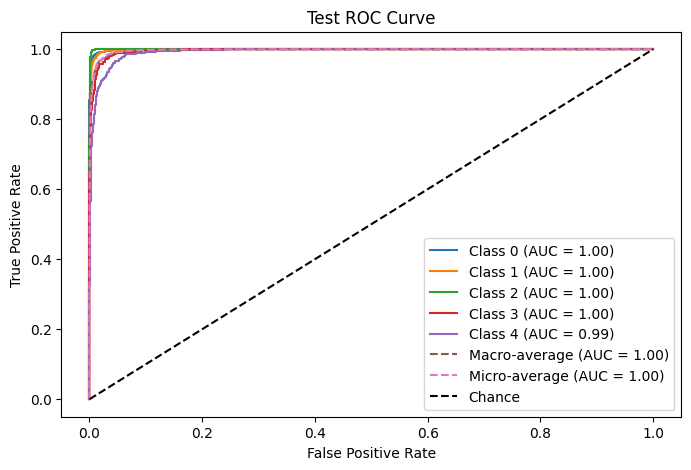

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

## Experimental model 4 -- adding dropout layers on different positions

In [28]:
from tensorflow.keras import models, layers, regularizers
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 512)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 512)      

Epoch 1/10
469/469 [==============================] - 27s 52ms/step - loss: 3.8386 - categorical_accuracy: 0.6497 - val_loss: 1.6058 - val_categorical_accuracy: 0.7866
Epoch 2/10
469/469 [==============================] - 24s 50ms/step - loss: 1.3449 - categorical_accuracy: 0.8429 - val_loss: 1.1096 - val_categorical_accuracy: 0.9022
Epoch 3/10
469/469 [==============================] - 23s 50ms/step - loss: 1.0761 - categorical_accuracy: 0.8715 - val_loss: 0.9884 - val_categorical_accuracy: 0.8850
Epoch 4/10
469/469 [==============================] - 23s 50ms/step - loss: 0.9257 - categorical_accuracy: 0.8837 - val_loss: 0.7718 - val_categorical_accuracy: 0.9266
Epoch 5/10
469/469 [==============================] - 23s 50ms/step - loss: 0.7626 - categorical_accuracy: 0.9062 - val_loss: 0.6816 - val_categorical_accuracy: 0.9172
Epoch 6/10
469/469 [==============================] - 23s 50ms/step - loss: 0.6541 - categorical_accuracy: 0.9176 - val_loss: 0.7871 - val_categorical_accuracy:

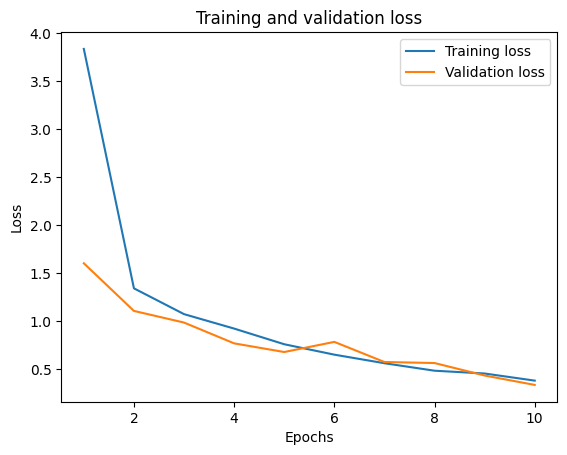

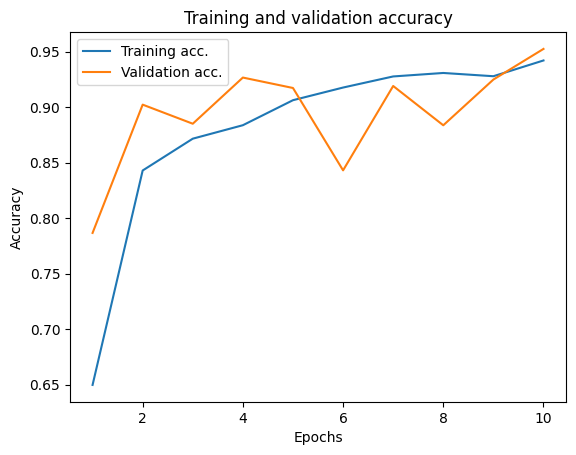

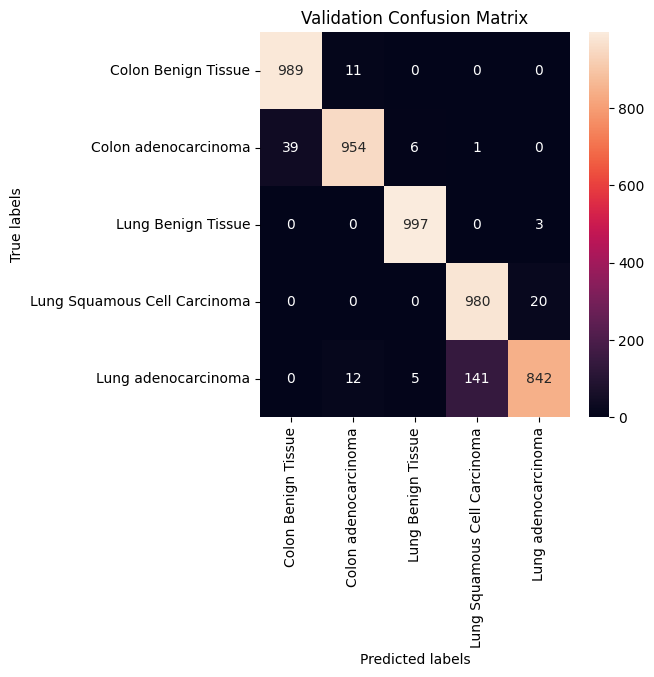

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.98      0.95      0.97      1000
           2       0.99      1.00      0.99      1000
           3       0.87      0.98      0.92      1000
           4       0.97      0.84      0.90      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



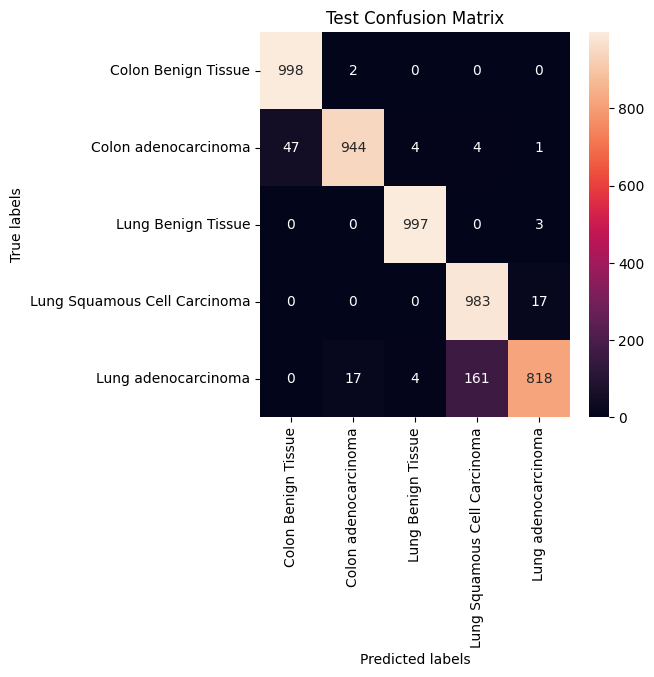

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1000
           1       0.98      0.94      0.96      1000
           2       0.99      1.00      0.99      1000
           3       0.86      0.98      0.92      1000
           4       0.97      0.82      0.89      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



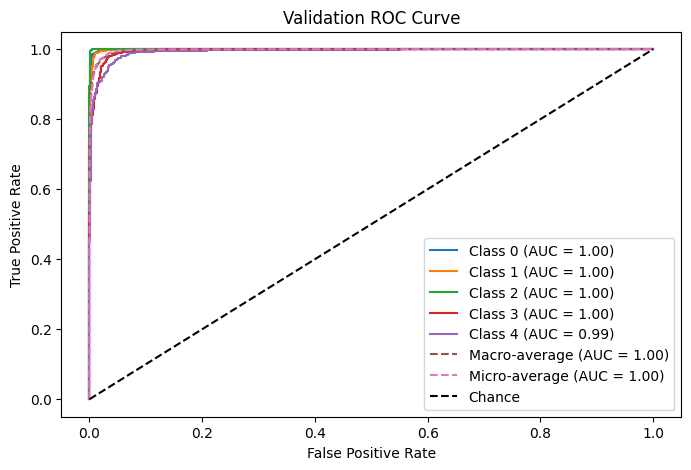

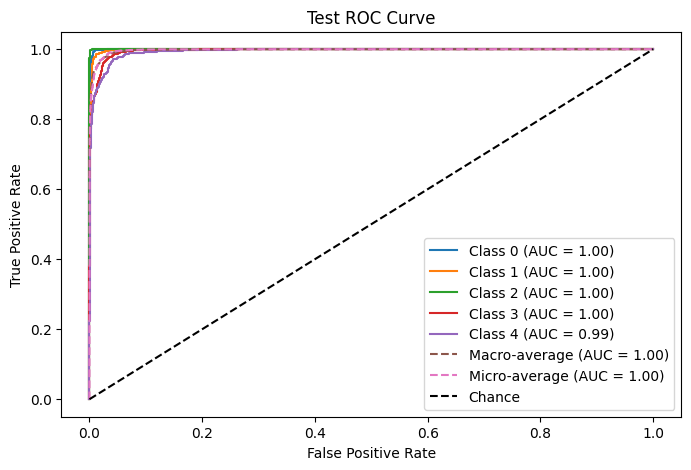

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

## Experimental model 5 -- adding more dense units

In [31]:
from tensorflow.keras import models, layers, regularizers
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 60, 60, 128)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 30, 30, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 512)      

Epoch 1/10
469/469 [==============================] - 28s 54ms/step - loss: 9.9136 - categorical_accuracy: 0.4259 - val_loss: 2.7326 - val_categorical_accuracy: 0.6338
Epoch 2/10
469/469 [==============================] - 25s 52ms/step - loss: 2.4380 - categorical_accuracy: 0.6803 - val_loss: 2.1782 - val_categorical_accuracy: 0.7546
Epoch 3/10
469/469 [==============================] - 25s 52ms/step - loss: 1.9279 - categorical_accuracy: 0.8179 - val_loss: 1.8488 - val_categorical_accuracy: 0.7468
Epoch 4/10
469/469 [==============================] - 25s 52ms/step - loss: 1.6039 - categorical_accuracy: 0.8569 - val_loss: 1.5110 - val_categorical_accuracy: 0.8524
Epoch 5/10
469/469 [==============================] - 24s 52ms/step - loss: 1.3583 - categorical_accuracy: 0.8833 - val_loss: 1.2305 - val_categorical_accuracy: 0.9070
Epoch 6/10
469/469 [==============================] - 24s 52ms/step - loss: 1.1764 - categorical_accuracy: 0.8959 - val_loss: 1.1342 - val_categorical_accuracy:

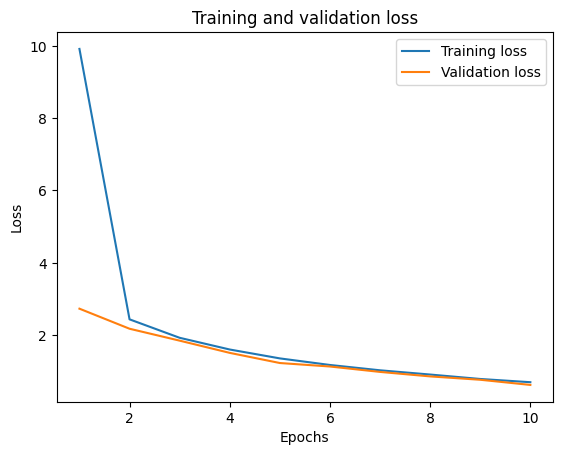

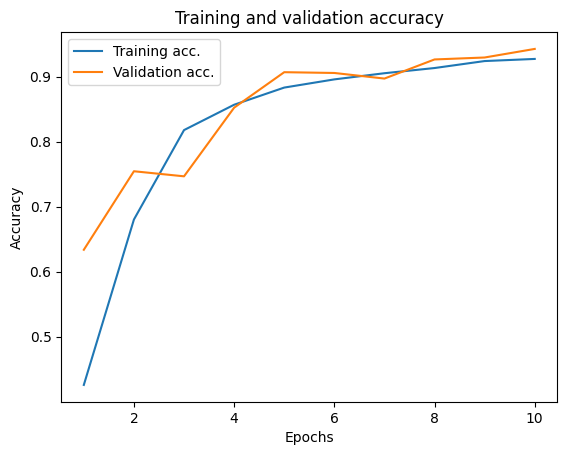

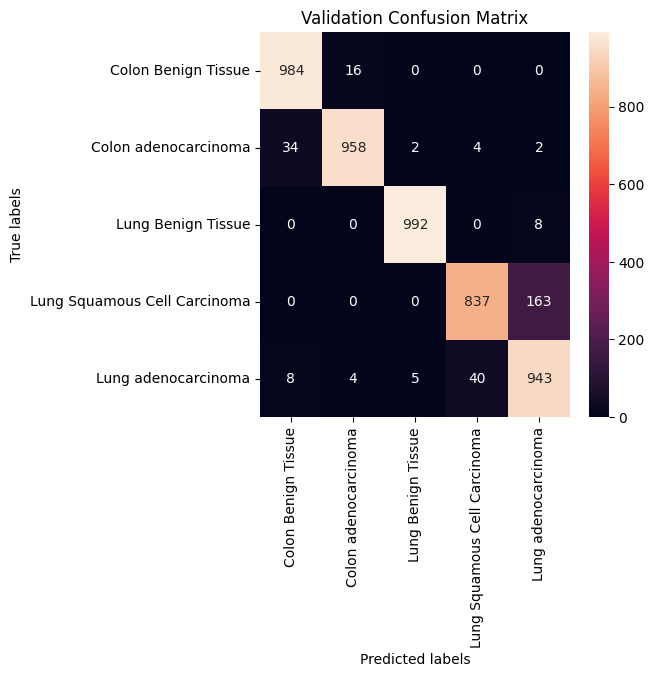

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.96      0.97      1000
           2       0.99      0.99      0.99      1000
           3       0.95      0.84      0.89      1000
           4       0.84      0.94      0.89      1000

    accuracy                           0.94      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.94      0.94      5000



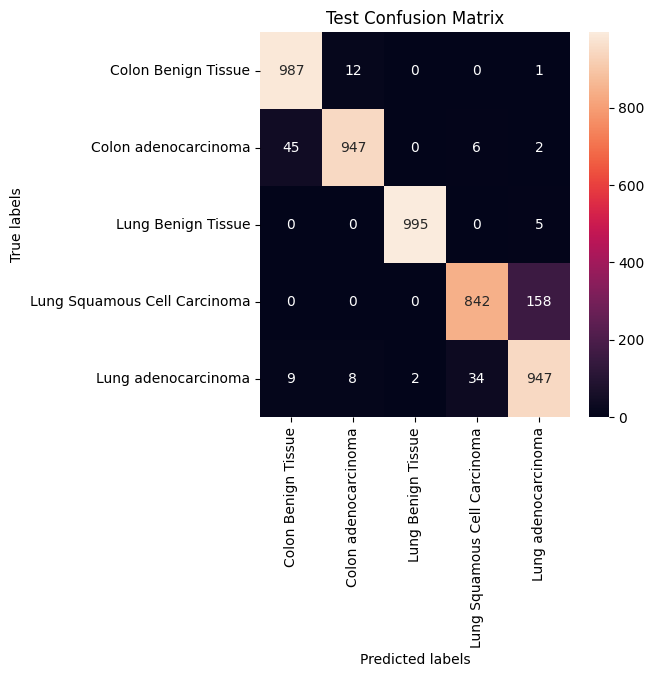

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.98      0.95      0.96      1000
           2       1.00      0.99      1.00      1000
           3       0.95      0.84      0.89      1000
           4       0.85      0.95      0.90      1000

    accuracy                           0.94      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.94      0.94      5000



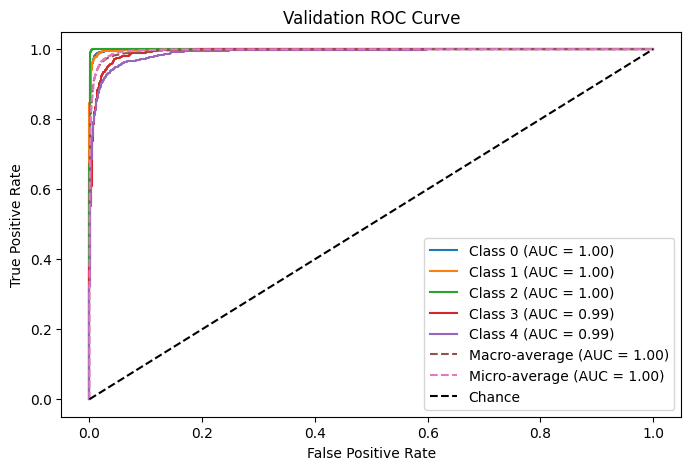

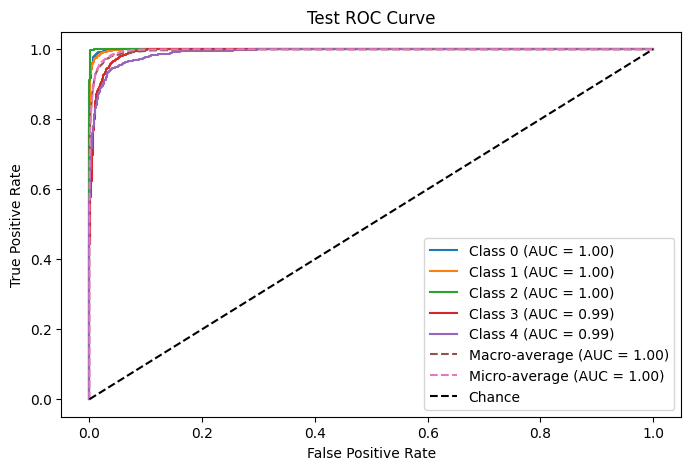

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

## Experimental model 6 -- adding more epochs

In [37]:
from tensorflow.keras import models, layers, regularizers
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(data.shape[1], data.shape[2], data.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 512)       590336    
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 512)       0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 512)       2359808   
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 15, 15, 512)      

Epoch 1/25
469/469 [==============================] - 23s 44ms/step - loss: 3.2708 - categorical_accuracy: 0.6768 - val_loss: 1.4003 - val_categorical_accuracy: 0.8010
Epoch 2/25
469/469 [==============================] - 20s 42ms/step - loss: 1.1943 - categorical_accuracy: 0.8428 - val_loss: 1.0516 - val_categorical_accuracy: 0.8678
Epoch 3/25
469/469 [==============================] - 20s 42ms/step - loss: 0.9560 - categorical_accuracy: 0.8910 - val_loss: 0.8463 - val_categorical_accuracy: 0.9192
Epoch 4/25
469/469 [==============================] - 20s 42ms/step - loss: 0.7727 - categorical_accuracy: 0.9283 - val_loss: 0.7574 - val_categorical_accuracy: 0.9116
Epoch 5/25
469/469 [==============================] - 20s 42ms/step - loss: 0.6906 - categorical_accuracy: 0.9283 - val_loss: 0.6456 - val_categorical_accuracy: 0.9428
Epoch 6/25
469/469 [==============================] - 20s 42ms/step - loss: 0.5857 - categorical_accuracy: 0.9421 - val_loss: 0.5493 - val_categorical_accuracy:

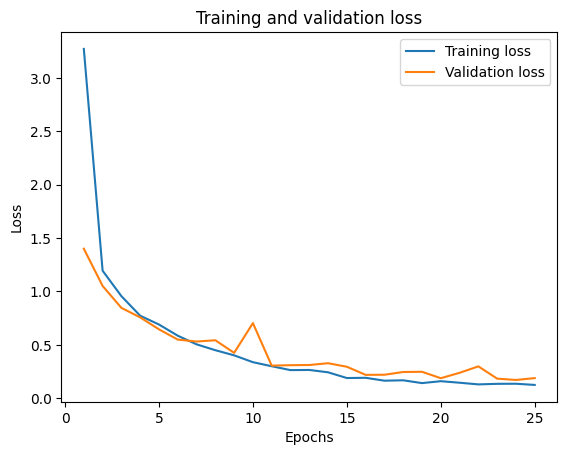

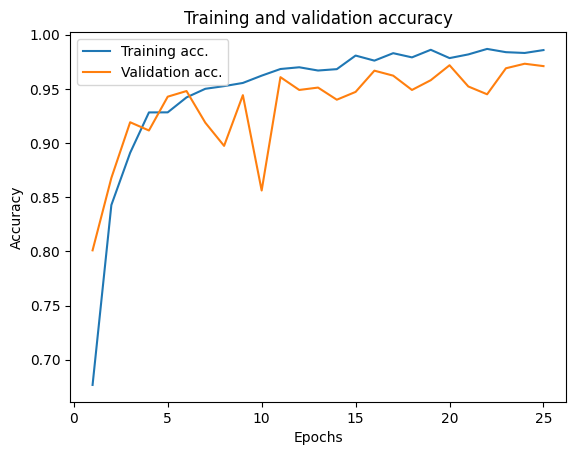

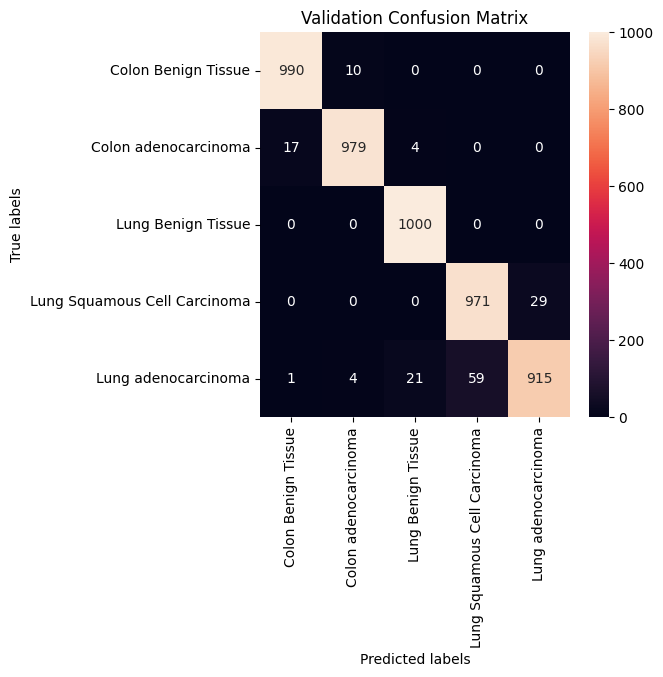

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.98      0.98      1000
           2       0.98      1.00      0.99      1000
           3       0.94      0.97      0.96      1000
           4       0.97      0.92      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



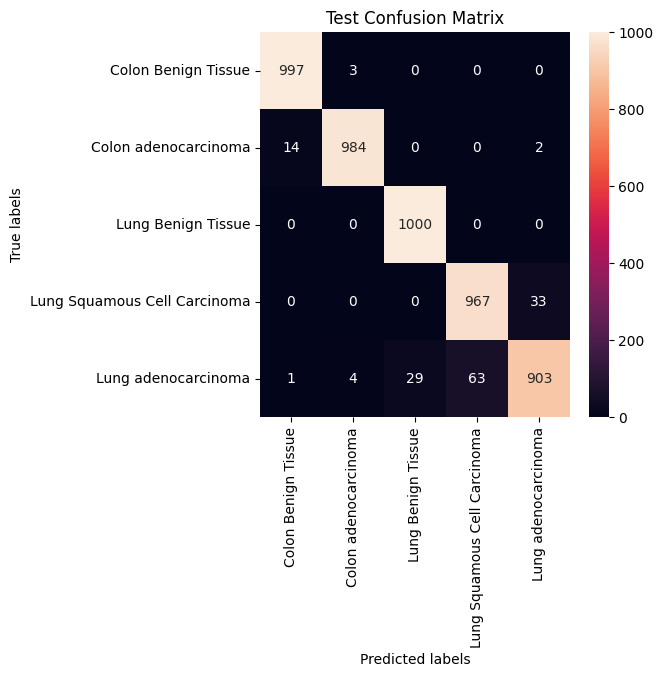

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       0.99      0.98      0.99      1000
           2       0.97      1.00      0.99      1000
           3       0.94      0.97      0.95      1000
           4       0.96      0.90      0.93      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



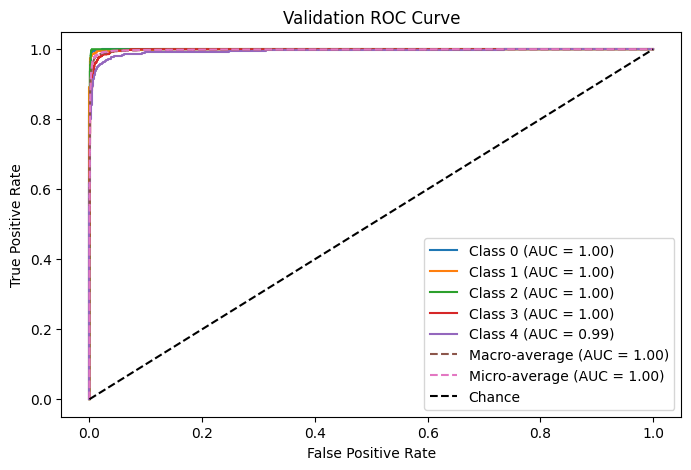

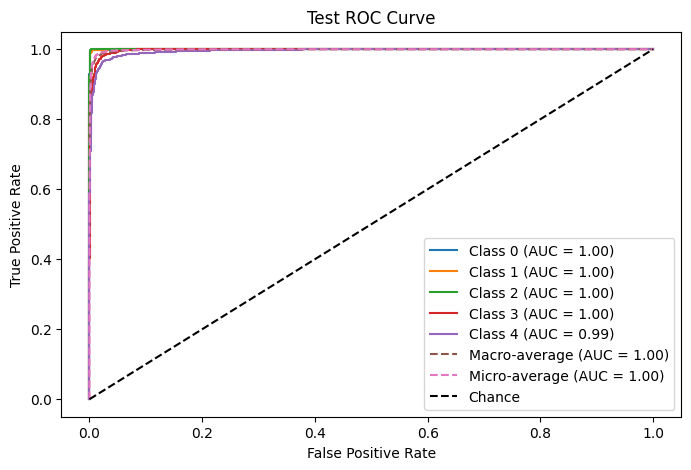

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")

# Transfer Learning Model


In [34]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_shape = (data.shape[1], data.shape[2], data.shape[3]))

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

for layer in model.layers:
  layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
dense1 = layers.Dense(128, activation = 'relu')(flat1)
dense2 = layers.Dense(32, activation = 'relu')(dense1)
output = layers.Dense(5, activation = 'softmax')(dense2)
model = Model(inputs = model.inputs, outputs = output)
model.summary()
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

Epoch 1/10
469/469 [==============================] - 12s 22ms/step - loss: 0.3454 - categorical_accuracy: 0.9120 - val_loss: 0.1515 - val_categorical_accuracy: 0.9504
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0798 - categorical_accuracy: 0.9709 - val_loss: 0.1219 - val_categorical_accuracy: 0.9592
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0488 - categorical_accuracy: 0.9826 - val_loss: 0.1219 - val_categorical_accuracy: 0.9614
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0509 - categorical_accuracy: 0.9823 - val_loss: 0.1737 - val_categorical_accuracy: 0.9486
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0514 - categorical_accuracy: 0.9831 - val_loss: 0.3145 - val_categorical_accuracy: 0.9434
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0397 - categorical_accuracy: 0.9872 - val_loss: 0.1531 - val_categorical_accuracy: 0.96

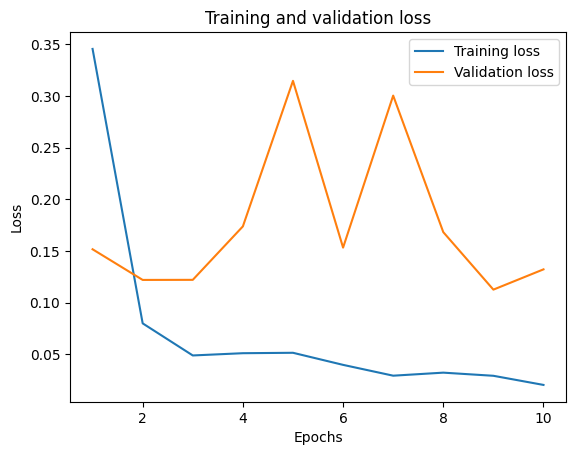

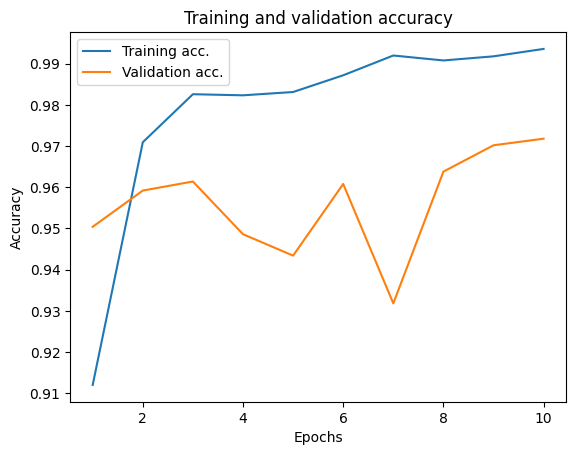

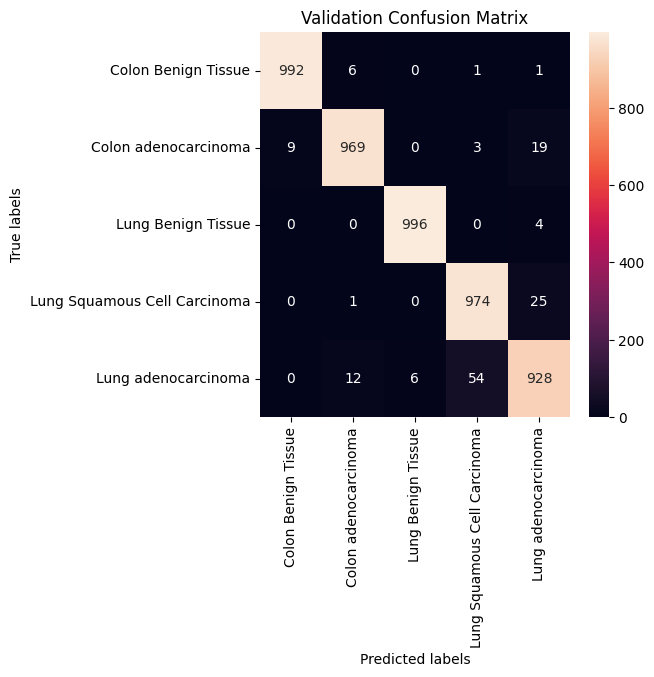

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.97      1000
           2       0.99      1.00      1.00      1000
           3       0.94      0.97      0.96      1000
           4       0.95      0.93      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



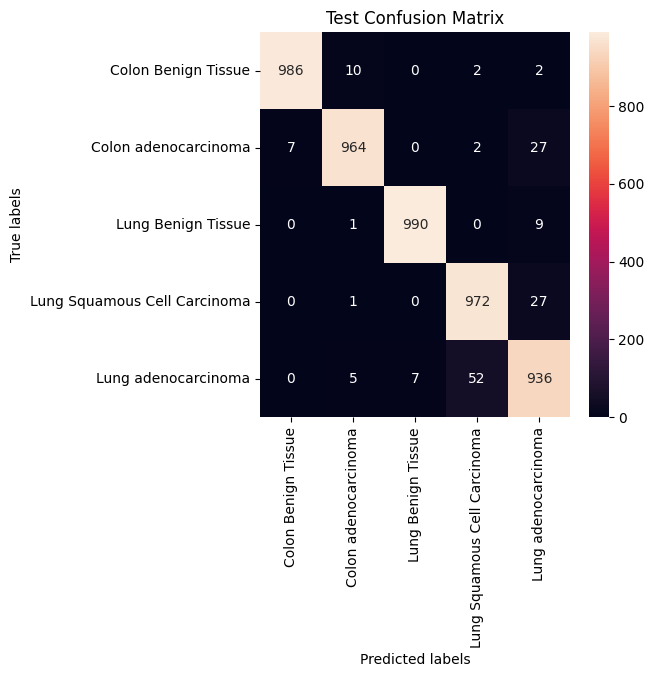

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.96      0.97      1000
           2       0.99      0.99      0.99      1000
           3       0.95      0.97      0.96      1000
           4       0.94      0.94      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



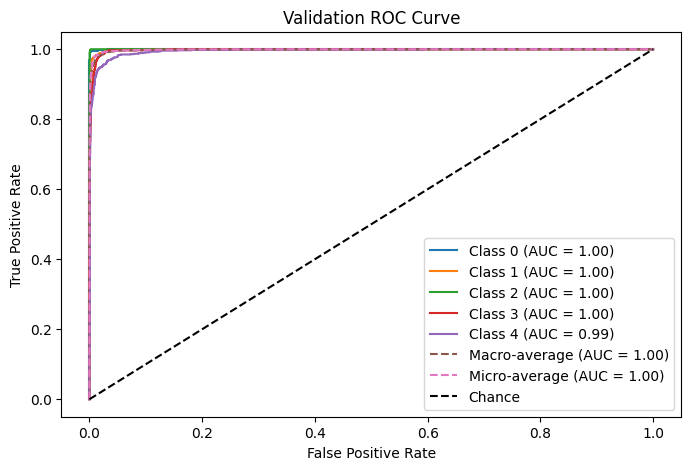

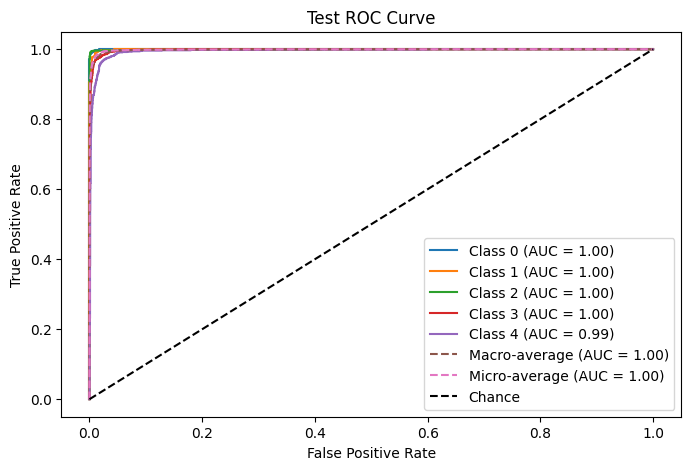

In [36]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
plot_loss_accuracy(history)
confusion_matrix_and_classreport(y_val, model.predict(X_val, verbose=0), "Validation")
confusion_matrix_and_classreport(y_test,  model.predict(X_test, verbose=0), "Test")
plot_roc_curve(y_val, model.predict(X_val, verbose=0), "Validation")
plot_roc_curve(y_test,  model.predict(X_test, verbose=0), "Test")